# Functions

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import os
import swifter

In [31]:
def mi_event_parsing(miinfofile):
    def nr_pci_track():
        if miinfofile.loc[i, "PCI"] == 65535: ## 65535 is for samgsung phone.
            nr_pci = '-'
        else:
            nr_pci = miinfofile.loc[i, "PCI"]
        return nr_pci

    nr_pci = None ## Initial Unknown
     
    lte_4G_handover_list = []   #4G 狀態下LTE eNB 的 handover
    
    nr_setup_list = []          #gNB cell addition
    nr_handover_list = []       #gNB cell changes (eNB stays the same)
    nr_removal_list = []        #gNB cell removal
        
    lte_5G_handover_list = []   #(eNB1, gNB1) -> (eNB2, gNB1) #gNB stays the same
    nr_lte_handover_list = []   #both NR cell and LTE cell have handover
    
    eNB_to_MN_list = []
    MN_to_eNB_list = []
    
    scg_failure_list = []       #gNB handover failure
    reestablish_list_type2 = [] #eNB handover failure
    reestablish_list_type3 = []
    
    SCell_rel = []
    SCell_add = []
    SCell_add_rel = []

    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    
    lte_failure = 0
    lte_failure_start_index = None
    
    handover_num = 0
    
    for i in range(len(miinfofile)):
        if miinfofile.loc[i, "type_id"] == "5G_NR_RRC_OTA_Packet":
            nr_pci = nr_pci_track()
            continue
            
        if miinfofile.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
                
        if miinfofile.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
                
        if miinfofile.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
           
        if (nr_handover or lte_handover or nr_release) and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num +=1
        
        
        #handover 種類分類
        #------------------------------------------------------------------------------
        if lte_handover and not nr_handover and not nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just lte cell handover event
            lte_handover = 0
            lte_4G_handover_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            

        if lte_handover and not nr_handover and nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:    # LTE Ho and nr release 
            lte_handover = 0
            nr_release = 0
            MN_to_eNB_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
        
        if nr_handover and not lte_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just nr cell handover event
            nr_handover = 0
            if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                nr_setup_list.append([miinfofile.loc[nr_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])       
            else:
                nr_handover_list.append([miinfofile.loc[nr_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            #additional judgement:
            #----------------------------
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #    print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != miinfofile.loc[nr_handover_start_index, "nr_pci"]): 
            #    print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, miinfofile.loc[nr_handover_start_index, "nr_pci"], nr_pci)
                
        if lte_handover and nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:      # both nr cell and lte cell handover event
            lte_handover = 0
            nr_handover = 0
            if nr_pci == miinfofile.loc[lte_handover_start_index, "nr_physCellId"]: 
                lte_5G_handover_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            else:
                ##############
                if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                    eNB_to_MN_list.append([miinfofile.loc[nr_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])       
                else:
                    nr_lte_handover_list.append([miinfofile.loc[lte_handover_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            
        if not lte_handover and  nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_release=0
            nr_removal_list.append([miinfofile.loc[nr_release_start_index, "Timestamp"], miinfofile.loc[i, "Timestamp"]])
            
        if miinfofile.loc[i, "scgFailureInformationNR-r15"]:
            scg_failure_list.append([miinfofile.loc[i, "Timestamp"], miinfofile.loc[i, "Timestamp"]]) 
            
        if miinfofile.loc[i, "rrcConnectionReestablishmentRequest"]:
            if lte_failure == 0:
                lte_failure = 1
                lte_failure_start_index = i
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishmentComplete"]:
            lte_failure = 0
            reestablish_list_type2.append([miinfofile.loc[lte_failure_start_index, "Timestamp"], miinfofile.loc[lte_failure_start_index, "Timestamp"]])
        if lte_failure and miinfofile.loc[i, "rrcConnectionReestablishmentReject"]:
            lte_failure = 0
            reestablish_list_type3.append([miinfofile.loc[lte_failure_start_index, "Timestamp"], miinfofile.loc[lte_failure_start_index, "Timestamp"]])
        
        # if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0' and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0):
        #     SCell_rel.append([miinfofile.loc[i, "Timestamp"]])
                              # May change        
        # if miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
        #     SCell_add.append([miinfofile.loc[i, "Timestamp"]])
        #                                                                                                                                    # May change
        # if (miinfofile.loc[i, "sCellToReleaseList-r10"] != '0'and miinfofile.loc[i, "sCellToReleaseList-r10"] != 0) and miinfofile.loc[i, "SCellToAddMod-r10"] and miinfofile.loc[i, "SCellIndex-r10.1"] != 'nr or cqi report':
        #     SCell_add_rel.append([miinfofile.loc[i, "Timestamp"], miinfofile.loc[i, "Timestamp"]])


    # return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, eNB_to_MN_list, MN_to_eNB_list, scg_failure_list, 
    # reestablish_list_type2, reestablish_list_type3, SCell_rel, SCell_add, SCell_add_rel], handover_num
    return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, eNB_to_MN_list, MN_to_eNB_list, scg_failure_list, 
    reestablish_list_type2, reestablish_list_type3], handover_num

def collect_ho_event(mi_rrc_df):
    l, _ = mi_event_parsing(mi_rrc_df)
    for i in range(len(l)):
        l[i] = [j[0] for j in l[i]]
    # d = {'lte': l[0], 'nr_setup': l[1], 'gNB_ho': l[2], 'nr_rel': l[3], "MN_changed": l[4],"MN_SN_changed": l[5],
    #  "eNB to MN changed": l[6], "MN to eNB changed": l[7], "gNB fail": l[8], "type2 fail": l[9], "type3 fail": l[10], 
    #  'SCell_rel': l[11], 'SCell_add': l[12], 'SCell_add_rel': l[13]}
    d = {'lte': l[0], 'nr_setup': l[1], 'gNB_ho': l[2], 'nr_rel': l[3], "MN_changed": l[4],"MN_SN_changed": l[5],
     "eNB to MN changed": l[6], "MN to eNB changed": l[7], "gNB fail": l[8], "type2 fail": l[9], "type3 fail": l[10]}
    return d

# Start

In [14]:
dir = "/home/wmnlab/D/database/2022-12-26/_Modem_Phone_Comparative_Exeriments"
trace = ['#01']
# file = ["dwnlnk_udp_latency.csv", "uplnk_udp_latency.csv", "dwnlnk_udp_loss_timestamp.csv","uplnk_udp_loss_timestamp.csv", ]
file = ["udp_dnlk_latency.csv", "udp_uplk_latency.csv", "udp_dnlk_loss_timestamp.csv", "udp_uplk_loss_timestamp.csv"]
DL_latency_files = []
UL_latency_files = []
DL_loss_files = []
UL_loss_files = []
rrc_files = []

for a in sorted(os.listdir(dir)):
    d0 = os.path.join(dir, a)
    # print(d0)
    for b in sorted(os.listdir(d0)):
        if b in trace:
            d1 = os.path.join(d0, b, 'data', file[0]) # 
            d2 = os.path.join(d0, b, 'data', file[1])
            d3 = os.path.join(d0, b, 'data', file[2])
            d4 = os.path.join(d0, b, 'data', file[3])
            d00 = os.path.join(d0, b, 'data') # 
            for c in sorted(os.listdir(d00)):
                if c.endswith('_rrc.csv'): # 
                    d5 = os.path.join(d00, c)
            DL_latency_files.append(d1)
            UL_latency_files.append(d2)
            DL_loss_files.append(d3)
            UL_loss_files.append(d4)
            rrc_files.append(d5)

In [15]:
DL_latency_dfs = []
for csv in DL_latency_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    DL_latency_dfs.append(df)

In [16]:
UL_latency_dfs = []
for csv in UL_latency_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    UL_latency_dfs.append(df)

In [17]:
DL_loss_dfs = []
for csv in DL_loss_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    DL_loss_dfs.append(df)

In [18]:
UL_loss_dfs = []
for csv in UL_loss_files:
    df = pd.read_csv(csv)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x))
    UL_loss_dfs.append(df)

In [22]:
rrc_dfs = []
for csv in rrc_files:
    df = pd.read_csv(csv)
    # df["time"] = df["time"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    rrc_dfs.append(df)

In [23]:
rrc_files

['/home/wmnlab/D/database/2022-12-26/_Modem_Phone_Comparative_Exeriments/qc00/#01/data/diag_log_qc00_2022-12-26_16-21-42_rrc.csv',
 '/home/wmnlab/D/database/2022-12-26/_Modem_Phone_Comparative_Exeriments/qc01/#01/data/diag_log_qc01_2022-12-26_16-21-42_rrc.csv',
 '/home/wmnlab/D/database/2022-12-26/_Modem_Phone_Comparative_Exeriments/sm07/#01/data/diag_log_sm07_2022-12-26_16-21-42_rrc.csv',
 '/home/wmnlab/D/database/2022-12-26/_Modem_Phone_Comparative_Exeriments/sm08/#01/data/diag_log_sm08_2022-12-26_16-21-42_rrc.csv']

In [32]:
HO_events = []
for df in rrc_dfs:
    x = collect_ho_event(df)
    HO_events.append(x)

In [33]:
HO_events[0].keys()

dict_keys(['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail'])

In [51]:
HO_events

[{'lte': [Timestamp('2022-12-26 16:21:08.218997'),
   Timestamp('2022-12-26 16:21:09.441933'),
   Timestamp('2022-12-26 16:21:14.515079'),
   Timestamp('2022-12-26 16:21:15.032964'),
   Timestamp('2022-12-26 16:22:55.982842'),
   Timestamp('2022-12-26 16:23:26.479327'),
   Timestamp('2022-12-26 16:23:40.365733'),
   Timestamp('2022-12-26 16:23:43.906763'),
   Timestamp('2022-12-26 16:23:52.438837'),
   Timestamp('2022-12-26 16:25:42.728342'),
   Timestamp('2022-12-26 16:25:54.934668'),
   Timestamp('2022-12-26 16:26:03.708951'),
   Timestamp('2022-12-26 16:26:05.046381'),
   Timestamp('2022-12-26 16:26:07.703279'),
   Timestamp('2022-12-26 16:26:11.239566'),
   Timestamp('2022-12-26 16:26:38.501368'),
   Timestamp('2022-12-26 16:26:53.035765'),
   Timestamp('2022-12-26 16:27:00.765757'),
   Timestamp('2022-12-26 16:27:54.711815'),
   Timestamp('2022-12-26 16:27:55.293972'),
   Timestamp('2022-12-26 16:29:03.803383'),
   Timestamp('2022-12-26 16:29:07.414575'),
   Timestamp('2022-12-26 

/tmp/ipykernel_799526/157803049.py:35: UserWarning: Legend does not support [] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend(
/tmp/ipykernel_799526/157803049.py:35: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend(


Text(0.5, 0.98, 'DL latency')

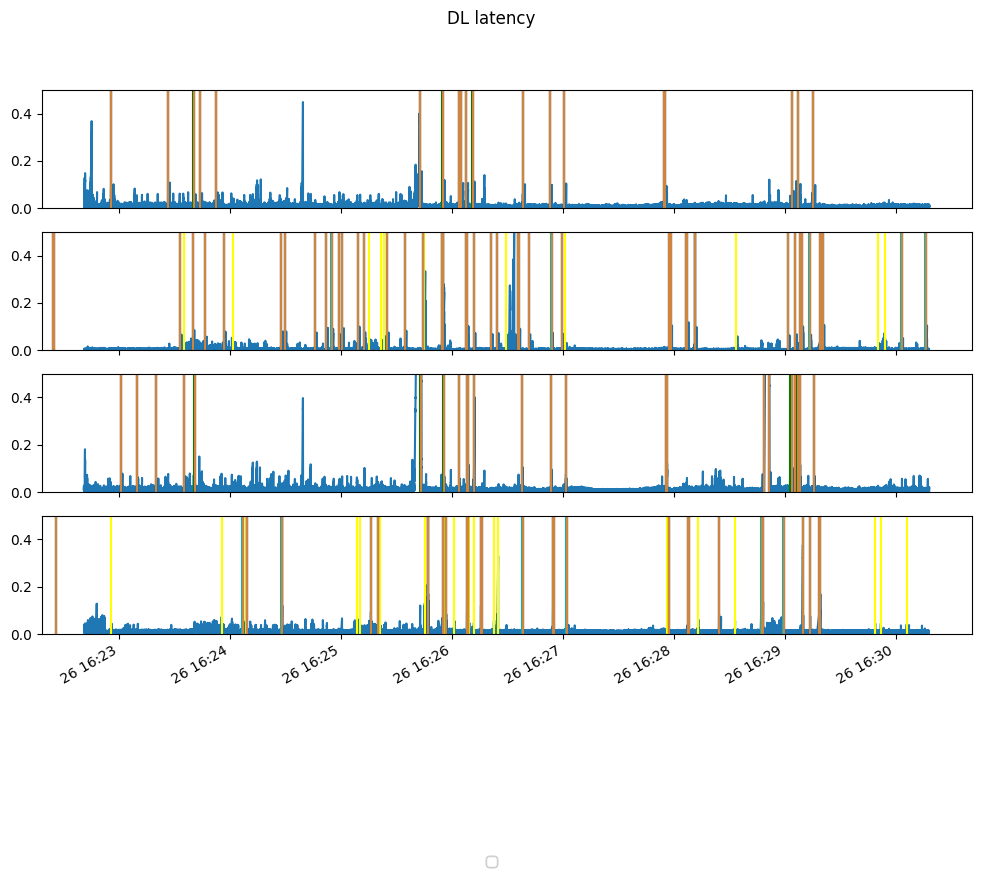

In [57]:
fig, axs = plt.subplots(4,1, figsize=(12, 8), sharex=True)
plt.gcf().autofmt_xdate()

for (i, df), df2 in zip(enumerate(DL_latency_dfs), DL_loss_dfs):
    x = df["Timestamp"].iloc[:]
    y = df["latency"].iloc[:]
    axs[i].plot(x, y)
    axs[i].set_ylim([0, 0.5])

    x2 = df2["Timestamp"].iloc[:]
    
    # axs[i].vlines(x2,ymin=0, ymax=1, color='r', label='loss') # Loss

left, right = axs[0].get_xlim()
plot = []
plot = ['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail']
# plot = [ 'lte','MN_changed','eNB to MN changed','type2 fail','type3 fail']
# plot = ['type2 fail','type3 fail','gNB fail']
# plot = ['nr_setup', 'gNB_ho', 'nr_rel', 'gNB']
# plot = ['SCell_add_rel']
color = ['g', 'm', 'yellow', 'k', 'c', 'orange', 'purple', 'cyan', 'olive', 'peru', 'navy', 'slategray', 'chocolate','black']
ho_plots = [None] * len(plot)
for i, A in enumerate(HO_events):
    for j, event in enumerate(A):
        if event in plot:
            x = A[event]
            # axs[i].vlines(x,ymin=0, ymax=1, color=color[j],label=event)
            ho_plots[i] = [axs[i].axvline(_x,color=color[j]) for _x in x]
    axs[i].set_xlim([left, right])
    if len(plot) != 0:
        # axs[i].legend()
        axbox = axs[3].get_position()
        handles = ho_plots
        labels = plot
        fig.legend(
            handles=handles, labels=labels,
            loc='lower center',
            bbox_to_anchor=[0, axbox.y0-0.3,1,1],
            # ncol=3,
            ncol=4,
        )

fig.suptitle('DL latency')

In [37]:
HO_events[0].keys()

dict_keys(['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail'])

Text(0.5, 0.98, 'UL latency')

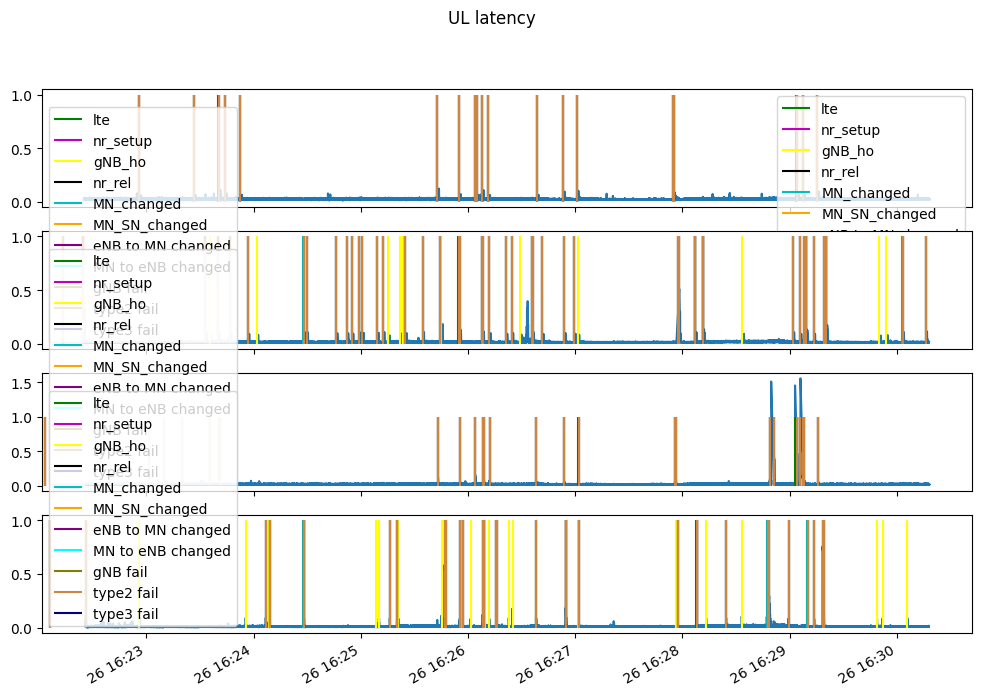

In [48]:
fig, axs = plt.subplots(4,1, figsize=(12, 8), sharex=True)
plt.gcf().autofmt_xdate()

for (i, df), df2 in zip(enumerate(UL_latency_dfs), UL_loss_dfs):
    x = df["Timestamp"].iloc[:]
    y = df["latency"].iloc[:]
    axs[i].plot(x, y)
    # axs[i].set_ylim([0, 1])

    x2 = df2["Timestamp"].iloc[:]
    # axs[i].vlines(x2,ymin=0, ymax=1, color='r')

left, right = axs[0].get_xlim()
plot = []
# plot = ['lte', 'MN_changed']
plot = ['lte', 'nr_setup', 'gNB_ho', 'nr_rel', 'MN_changed', 'MN_SN_changed', 'eNB to MN changed', 'MN to eNB changed', 'gNB fail', 'type2 fail', 'type3 fail']
# plot = ['nr_setup', 'gNB_ho', 'nr_rel', 'gNB', 'gNB fail']
# plot = ['SCell_add_rel']
color = ['g', 'm', 'yellow', 'k', 'c', 'orange', 'purple', 'cyan', 'olive', 'peru', 'navy', 'slategray', 'chocolate','black']
ho_plots = [None] * len(plot)
for i, A in enumerate(HO_events):
    for j, event in enumerate(A):
        if event in plot:
            x = A[event]
            axs[i].vlines(x,ymin=0, ymax=1, color=color[j],label=event)
            # ho_plots[i] = axs[i].vlines(x,ymin=0, ymax=1, color=color[j])
    axs[i].set_xlim([left, right])
    if len(plot) != 0:
        axs[i].legend()
        # axbox = axs[3].get_position()
        # handles = ho_plots
        # labels = plot
        # fig.legend(
        #     handles=handles, labels=labels,
        #     loc='lower center',
        #     bbox_to_anchor=[0, axbox.y0-0.3,1,1],
        #     # ncol=3,
        #     ncol=4,
        # )
fig.suptitle('UL latency')

<Figure size 1200x800 with 0 Axes>

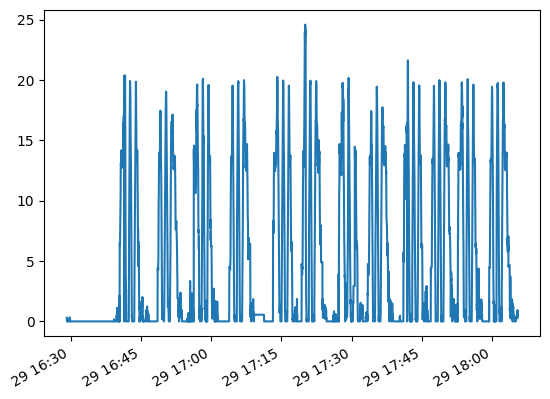

<Figure size 1200x800 with 0 Axes>

In [ ]:
f = '/home/wmnlab/123.csv'
df = pd.read_csv(f)
df["time"] = df["time"].swifter.apply(lambda x: pd.to_datetime(x))
plt.plot(df["time"], df[" GPSSpeed"])
plt.gcf().autofmt_xdate()
plt.figure(figsize=(12,8))

In [ ]:
def get_loacation_and_time(cellinfo_df, savefilename, cut=None):
    f = open(savefilename, 'w')
    f.write("time, latitude, longitude, LTE_RSRP, GPSSpeed\n")
    for i in range(len(cellinfo_df)):
        if cut != None and (cellinfo_df.loc[i, "GPSLat"] != '-' and cellinfo_df.loc[i, "Date"]<cut):
            print("%s,%s,%s,%s,%s"%(cellinfo_df["Date"].iloc[i], cellinfo_df.loc[i, "GPSLat"],
            cellinfo_df.loc[i, "GPSLon"], cellinfo_df.loc[i, "LTE_RSRP"], cellinfo_df.loc[i, "GPSSpeed"]), file=f)
        elif cellinfo_df.loc[i, "GPSLat"] != '-':
            print("%s,%s,%s,%s,%s"%(cellinfo_df["Date"].iloc[i], cellinfo_df.loc[i, "GPSLat"],
            cellinfo_df.loc[i, "GPSLon"], cellinfo_df.loc[i, "LTE_RSRP"], cellinfo_df.loc[i, "GPSSpeed"]), file=f)

    f.close()

In [ ]:
cellinfo_path = "/home/wmnlab/Code_Test_Space/sheng-ru/2022-11-29/_Bandlock_Udp_B1_B3/sm05/#01/middle/cimon_sm05_2022-11-29_16-29-06_new.csv"
cellinfo_df = pd.read_csv(cellinfo_path)
cellinfo_df["Date"] = cellinfo_df["Date"].swifter.apply(lambda x: pd.to_datetime(x))
# cellinfo_df["Date"] = cellinfo_df["Date"].swifter.apply(lambda x: str(pd.to_datetime(x)).split(' ')[1])
# cut = dt.datetime(2022, 11, 29, 16, 46, 00)
cut = None

save_name = "/home/wmnlab/123.csv"
get_loacation_and_time(cellinfo_df=cellinfo_df, savefilename=save_name, cut=cut)

In [20]:
cellinfo_df["Date"][1]

NameError: name 'cellinfo_df' is not defined